In [ ]:
import numpy as np
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix as csr
from scipy.sparse import lil_matrix as lil
from scipy.sparse.linalg import eigs, eigsh
import timeit
import scipy.sparse as sps
from numpy import linalg as LA

# **Hubbard model Exact Diagonalization (Considering System symmetry)**

In [ ]:
def Hubbard_ED(n):
    
    ###############
    # Parameters
    ###############
    
    N = n    #Number of sites
    t = 1    #Hopping term
    mu = 0.1 #On-site term

    #Pauli matrices:
    sigma_z = csr(np.array([[1, 0], [0, -1]]))
    sigma_m = csr(np.array([[0, 0], [1, 0]]))
    I = csr(np.eye(2))
    
    #########################################
    #   Construction of Fermionic operators
    #########################################
    
    start = timeit.default_timer()
    
    c = dict(); z = dict(); i_d = dict() #C is annihilation opperator and C_dagger is creation operator; 
    Z = dict(); C = dict(); Id = dict()
    
    z[1] = csr(sigma_z.toarray());
    Id[1] = I;
    
    for i in range(2,N):
        z[i] = sps.kron(sigma_z,z[i-1]).toarray(); Z[i] = csr(z[i])
        Id[i] = csr(np.eye(2**i)); 

    Id[N] = csr(np.eye(2**N))
    
    for i in range(1,N+1):
        if i!=1 and i!=N:
            c[i] = sps.kron(sps.kron(z[i-1],sigma_m),Id[N-i]).toarray()
            C[i] = csr(c[i])
        if i==1:
            c[i] = sps.kron(sigma_m,Id[N-i]).toarray()
            C[i] = csr(c[i])
        if i==N:
            c[i] = sps.kron(z[i-1],sigma_m).toarray()
            C[i] = csr(c[i])
            
    stop=timeit.default_timer()
    t_operators = stop- start
        
    ####################################################################
    #   Construction of Many-body Hamiltonian matrix & Number operator
    ####################################################################
    
    start = timeit.default_timer()
    
    Num_op = np.zeros((2**N, 2**N)); Num_op = csr(Num_op)  #Number operator
    Num_op = csr.transpose(C[N])*C[N]

    H = np.zeros((2**N, 2**N)); H = csr(H)  #Hamiltonian
    
    #Imposing PBC
    H = - mu*(csr.transpose(C[N])*C[N])*((-1)**N) -t*(csr.transpose(C[N])*C[1] + csr.transpose(C[1])*C[N])
    
    #Sum over all sites
    for i in range(1,N):
        Num_op = csr.transpose(C[i])*C[i] + Num_op
        H += -t*(csr.transpose(C[i+1])*C[i]+ csr.transpose(C[i])*C[i+1]) - mu*(csr.transpose(C[i])*C[i])*((-1)**i)\
        + U*(csr.transpose(C[i+1])*C[i]+ csr.transpose(C[i])*C[i+1])

    H = (H + csr.transpose(H))/2 #Making sure Hamiltonian is hermitian
    
    stop=timeit.default_timer()
    sum_time = stop-start
    ###############
    # First method:                                
    ########################################################
    # Exact digonalization for the entire Hamiltonian matrix
    ########################################################

    start=timeit.default_timer()
    
    Energy, State = LA.eigh(H.todense())
    Energy = np.sort(Energy)
    Energy.tolist() #Energy spectrum from first method
    
    stop=timeit.default_timer()
    total_diag_time = stop-start
    ###############
    # Second method: 
    #####################################################################
    # Exact digonalization for each block in block diagonal Hamiltonian 
    #####################################################################
    ########################
    #  Checking [H,N] = 0
    ########################
    
    Commutator = H.todense()*Num_op.todense() - Num_op.todense()*H.todense() # [H,Lz] = H*Lz - Lz*H
    A = np.transpose(Commutator)*Commutator
    Check = np.trace(A) # A = 0 if Tr(A_dagger*A) = 0
    
    ###############################################################################################################
    #  Sorting Num_op and Permuting Hamiltonian with sorted indices (Using System Symmetry to block diagonalize H)
    ###############################################################################################################
    
    start=timeit.default_timer()
    
    Num_op_diag = np.diag(Num_op.todense())
    s2  = np.argsort(Num_op_diag) #indices after sorting Lz_diag
    Num_op_sorted = np.sort(Num_op_diag)
    
    U = lil((2**N, 2**N)) #U is Transformation matrix
    for i in range(2**N):
        U[s2[i], i] = 1
        
    #Basis Transformation:    
    H_sorted = (np.transpose(U)*H)*U #H_sorted = U_dagger*H*U (H_sorted i.e. Block diagonl Hamiltonian)
    
    stop=timeit.default_timer()
    transformation_time = stop-start
    
    ########################
    # Block diagonalization
    ########################
    start=timeit.default_timer()
    
    #Calculating size of each block by counting how many times each number is repeated in Lz
    [a,b] = np.unique(Num_op_sorted, return_index=False, return_inverse=False, return_counts=True)
    new_b = np.delete(b,[0,N])
    
    first = 1
    Energy_Block_Diag =[] #Energy spectrum from second method 
    for i in new_b:
        last = first + i
        En_BD,S_BD = LA.eigh(H_sorted[first:last,first:last].todense()) #diagonalizing each block
        En_BD=list(En_BD)
        Energy_Block_Diag.append(En_BD)
        first = last

    #The first and last elements in H_sorted are single numbers
    Energy_Block_Diag.append(H_sorted[0,0]) 
    Energy_Block_Diag.append(H_sorted[2**N -1,2**N -1])
    
    def flatten_list(inp_list): #function for flatting the Block diagonal energy list 
        flat_list = []
        # Iterate through the outer list
        for element in inp_list:
            if type(element) is list:
                # If the element is of type list, iterate through the sublist
                for item in element:
                    flat_list.append(item)
            else:
                flat_list.append(element)
        return flat_list

    Energy_Block_Diag = flatten_list(Energy_Block_Diag)
    Energy_Block_Diag.sort()
    
    stop=timeit.default_timer()
    block_diag_time = stop-start
    
    ####################
    # Calculating Time
    ####################
    First_Time =  t_operators + sum_time + total_diag_time
    Second_Time = t_operators + sum_time + transformation_time + block_diag_time
    
    return Energy_Block_Diag, Energy, Check, H_sorted, block_diag_time, total_diag_time

# N = 8

In [ ]:
En_BD8, En8, Check8, H_sorted8, block_diag_time8, total_diag_time8  = Hubbard_ED(n=8)

In [ ]:
#Checking that [H,N] = 0
print('[H,N] =' ,Check8 )

[H,N] = 0.0


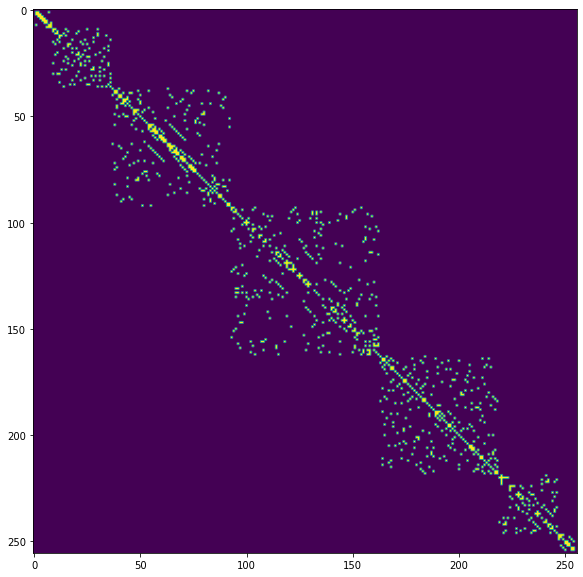

In [ ]:
#Checking that H is block diagonalized
H_plot8 = H_sorted8.todense()
H_plot8[H_plot8!= 0] = 1
fig = plt.figure(figsize=(10,10)) 
plt.imshow(H_plot8)

After Taking sum over the entire spectrum the Difference between two methodes is 6.569195037102464e-15


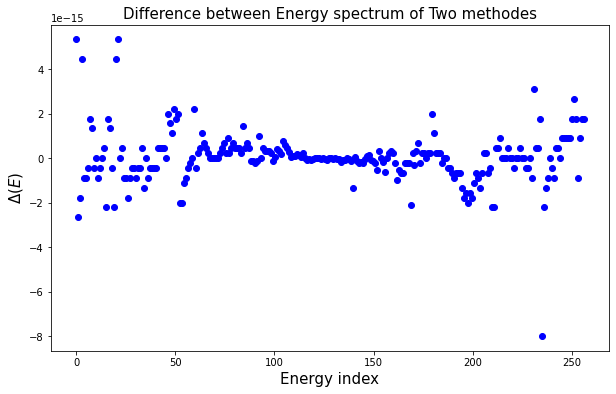

In [ ]:
#The Difference between Energy spectrum obtained from each method (Diagonalizing the Entire H and Diagonalizing each block)
Difference8 = -(En_BD8 - En8)
fig = plt.figure(figsize=(10,6))
x = np.linspace(0,2**8,2**8)
plt.scatter(x,Difference8,marker = "o",c='b')
plt.xlabel('Energy index',fontsize=15)
plt.ylabel('$\Delta(E)$',fontsize=15)
plt.title('Difference between Energy spectrum of Two methodes',fontsize=15)
print('After Taking sum over the entire spectrum the Difference between two methodes is' , sum (Difference8 ) )

In [ ]:
Time_difference8 = abs(total_diag_time8 - block_diag_time8) 
print('conserved time is' ,Time_difference8)

conserved time is 0.03514601000000539


In [ ]:
Ground_state1 = En8[0]
Ground_state2 = En_BD8[0]
print('Ground state Energy in first method = ' ,Ground_state1)
print('Ground state Energy in second method = ' ,Ground_state2)

Ground state Energy in first method =  -4.937987815201641
Ground state Energy in second method =  -4.937987815201646


# N = 12

In [ ]:
En_BD12, En12, Check12, H_sorted12, block_diag_time12, total_diag_time12  = Hubbard_ED(n=12)

In [ ]:
#Checking that [H,N] = 0
print('[H,N] =' ,Check12 )

[H,N] = 0.0


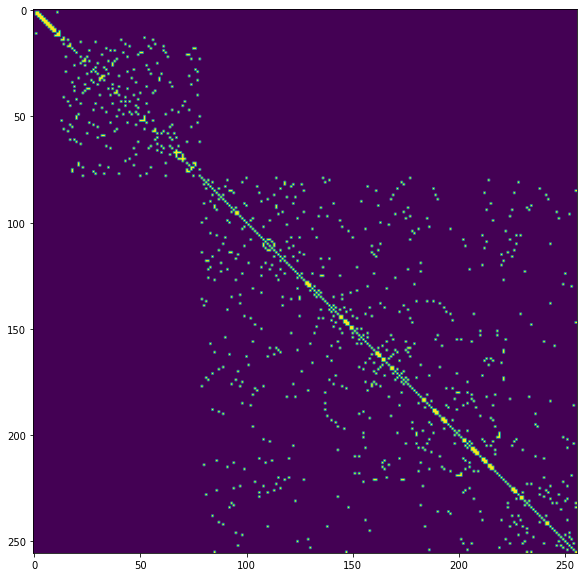

In [ ]:
#Checking that H is block diagonalized
H_plot12 = H_sorted12.todense()
H_plot12[H_plot12!= 0] = 1
fig = plt.figure(figsize=(10,10)) 
plt.imshow(H_plot12[0:256,0:256])

After Taking sum over the entire spectrum the Difference between two methodes is -1.1380716361722278e-13


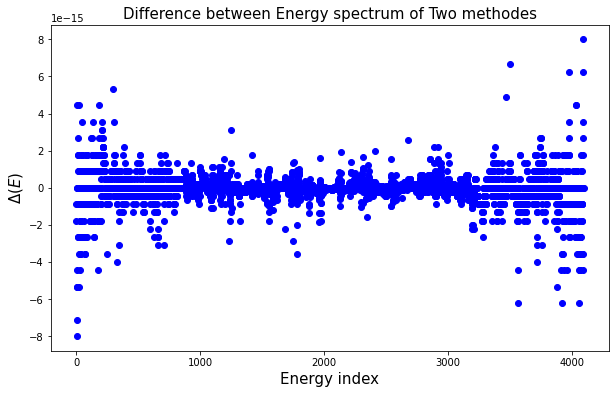

In [ ]:
#The Difference between Energy spectrum obtained from each method (Diagonalizing the Entire H and Diagonalizing each block)
Difference12 = -(En_BD12 - En12)
fig = plt.figure(figsize=(10,6))
x = np.linspace(0,2**12,2**12)
plt.scatter(x,Difference12,marker = "o",c='b')
plt.xlabel('Energy index',fontsize=15)
plt.ylabel('$\Delta(E)$',fontsize=15)
plt.title('Difference between Energy spectrum of Two methodes',fontsize=15)
print('After Taking sum over the entire spectrum the Difference between two methodes is' , sum (Difference12 ) )

In [ ]:
Time_difference12 = abs(total_diag_time12 - block_diag_time12) 
print('conserved time is' ,Time_difference12)

conserved time is 16.89633892200004


In [ ]:
Ground_state1 = En12[0]
Ground_state2 = En_BD12[0]
print('Ground state Energy in first method = ' ,Ground_state1)
print('Ground state Energy in second method = ' ,Ground_state2)

Ground state Energy in first method =  -7.582343878253749
Ground state Energy in second method =  -7.582343878253747
